In [1]:
import numpy as np
import itertools
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
from nltk.stem.snowball import SnowballStemmer
import scipy
from scipy import spatial
from scipy.sparse import hstack
import re
from textblob import TextBlob, Word
import gensim
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
starter_dataset = pd.read_feather('data/processed_data')
starter_dataset.head()

,cmc,oracle_text,power,toughness,colors,produced_mana,loyalty,devotion,phyrexian_mana,flavor_size,...,Tribal,World,Creature,Instant,Land,Artifact,Planeswalker,Sorcery,Enchantment,Equipment
0,6.0,All Sliver creatures have double strike. Abili...,3,3,1,0,0,1,0,228,...,0,0,0,1,0,0,0,0,0,0
1,2.0,"When CARDNAME enters the battlefield, you may ...",2,2,1,0,0,2,0,71,...,0,0,0,1,0,0,0,0,0,0
2,3.0,"Flying\nWhen CARDNAME enters the battlefield, ...",1,2,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1.0,"When CARDNAME dies, put a +1/+1 counter on tar...",2,1,1,0,0,1,0,71,...,0,0,0,1,0,0,0,0,0,0
4,3.0,"Whenever you draw your second card each turn, ...",3,1,1,0,0,1,0,99,...,0,0,0,1,0,0,0,0,0,0


### To Lower Case

In [3]:
starter_dataset['oracle_text'] = starter_dataset['oracle_text'].apply(lambda text: text.lower())
starter_dataset.head()

,cmc,oracle_text,power,toughness,colors,produced_mana,loyalty,devotion,phyrexian_mana,flavor_size,...,Tribal,World,Creature,Instant,Land,Artifact,Planeswalker,Sorcery,Enchantment,Equipment
0,6.0,all sliver creatures have double strike. abili...,3,3,1,0,0,1,0,228,...,0,0,0,1,0,0,0,0,0,0
1,2.0,"when cardname enters the battlefield, you may ...",2,2,1,0,0,2,0,71,...,0,0,0,1,0,0,0,0,0,0
2,3.0,"flying\nwhen cardname enters the battlefield, ...",1,2,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1.0,"when cardname dies, put a +1/+1 counter on tar...",2,1,1,0,0,1,0,71,...,0,0,0,1,0,0,0,0,0,0
4,3.0,"whenever you draw your second card each turn, ...",3,1,1,0,0,1,0,99,...,0,0,0,1,0,0,0,0,0,0


### Remocão de Stop Words

In [4]:
nltk.download('stopwords')
sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielbrai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
starter_dataset['oracle_text'].apply(lambda t: " ".join(t for t in t.split() if t not in sw))
starter_dataset.head()

,cmc,oracle_text,power,toughness,colors,produced_mana,loyalty,devotion,phyrexian_mana,flavor_size,...,Tribal,World,Creature,Instant,Land,Artifact,Planeswalker,Sorcery,Enchantment,Equipment
0,6.0,all sliver creatures have double strike. abili...,3,3,1,0,0,1,0,228,...,0,0,0,1,0,0,0,0,0,0
1,2.0,"when cardname enters the battlefield, you may ...",2,2,1,0,0,2,0,71,...,0,0,0,1,0,0,0,0,0,0
2,3.0,"flying\nwhen cardname enters the battlefield, ...",1,2,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1.0,"when cardname dies, put a +1/+1 counter on tar...",2,1,1,0,0,1,0,71,...,0,0,0,1,0,0,0,0,0,0
4,3.0,"whenever you draw your second card each turn, ...",3,1,1,0,0,1,0,99,...,0,0,0,1,0,0,0,0,0,0


### Remoção de Pontuação

In [6]:
starter_dataset['oracle_text'] = starter_dataset['oracle_text'].str.replace('[^\w\s]', '')
starter_dataset['oracle_text'].head()

0    all sliver creatures have double strike. abili...
1    when cardname enters the battlefield, you may ...
2    flying\nwhen cardname enters the battlefield, ...
3    when cardname dies, put a +1/+1 counter on tar...
4    whenever you draw your second card each turn, ...
Name: oracle_text, dtype: object

### Remoção de Números

In [7]:
starter_dataset['oracle_text'] = starter_dataset['oracle_text'].str.replace('[0-9]', '')
starter_dataset['oracle_text'].head()

0    all sliver creatures have double strike. abili...
1    when cardname enters the battlefield, you may ...
2    flying\nwhen cardname enters the battlefield, ...
3    when cardname dies, put a +1/+1 counter on tar...
4    whenever you draw your second card each turn, ...
Name: oracle_text, dtype: object

### Remoção de Símbolos de Quebra de Linha

In [8]:
starter_dataset['oracle_text'] = starter_dataset['oracle_text'].str.replace('\n', ' ')
starter_dataset['oracle_text'].head()

0    all sliver creatures have double strike. abili...
1    when cardname enters the battlefield, you may ...
2    flying when cardname enters the battlefield, i...
3    when cardname dies, put a +1/+1 counter on tar...
4    whenever you draw your second card each turn, ...
Name: oracle_text, dtype: object

In [9]:
dropped_columns_df = starter_dataset.drop(columns=['power', 'toughness', 'loyalty'], axis=1)
dropped_columns_df['cmc'] = dropped_columns_df['cmc'].fillna(0.0).astype(float)
dropped_columns_df.drop('oracle_text', axis=1, inplace=True)
dropped_columns_df.astype(int)
dropped_columns_df['oracle_text'] = starter_dataset['oracle_text']
dropped_columns_df.head()

,cmc,colors,produced_mana,devotion,phyrexian_mana,flavor_size,abilities,Basic,Legendary,Snow,...,World,Creature,Instant,Land,Artifact,Planeswalker,Sorcery,Enchantment,Equipment,oracle_text
0,6.0,1,0,1,0,228,0,0,0,0,...,0,0,1,0,0,0,0,0,0,all sliver creatures have double strike. abili...
1,2.0,1,0,2,0,71,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"when cardname enters the battlefield, you may ..."
2,3.0,1,0,1,0,0,2,0,0,0,...,0,0,1,0,0,0,0,0,0,"flying when cardname enters the battlefield, i..."
3,1.0,1,0,1,0,71,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"when cardname dies, put a +1/+1 counter on tar..."
4,3.0,1,0,1,0,99,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"whenever you draw your second card each turn, ..."


### Count Words

In [10]:
cv = CountVectorizer()
cv_oracle_text = cv.fit_transform(starter_dataset['oracle_text'])
# dropped_columns_df['cv'] = cv_oracle_text.toarray().tolist()

### TF-IDF

In [11]:
tf = TfidfVectorizer()
tfidf_oracle_text = tf.fit_transform(starter_dataset['oracle_text'])
# dropped_columns_df['tfidf'] = tfidf_oracle_text.toarray().tolist()

### Padronização os dados

In [12]:
scaler = StandardScaler()
caracteristicas_numericas = scaler.fit_transform(dropped_columns_df.drop('oracle_text', axis=1))
caracteristicas_numericas

array([[ 1.53501434, -0.02542122, -0.27410798, ..., -0.18618175,
        -0.10443446, -0.35373889],
       [-0.73735712, -0.02542122, -0.27410798, ..., -0.18618175,
        -0.10443446, -0.35373889],
       [-0.16926425, -0.02542122, -0.27410798, ..., -0.18618175,
        -0.10443446, -0.35373889],
       ...,
       [ 0.39882861, -0.02542122, -0.27410798, ..., -0.18618175,
        -0.10443446,  2.82694393],
       [ 0.96692148, -0.02542122, -0.27410798, ..., -0.18618175,
        -0.10443446, -0.35373889],
       [-0.16926425, -0.02542122, -0.27410798, ..., -0.18618175,
        -0.10443446, -0.35373889]])

### Combinação dos dados

In [13]:
feature_matrix_cv = pd.concat([pd.DataFrame(caracteristicas_numericas), pd.DataFrame(cv_oracle_text.toarray())], axis=1)
feature_matrix_cv

,0,1,2,3,4,5,6,7,8,9,...,10956,10957,10958,10959,10960,10961,10962,10963,10964,10965
0,1.535014,-0.025421,-0.274108,-0.189785,-0.038240,3.351999,-0.774178,-0.021127,-0.316665,-0.066021,...,0,0,0,0,0,0,0,0,0,0
1,-0.737357,-0.025421,-0.274108,1.347888,-0.038240,0.326671,-0.774178,-0.021127,-0.316665,-0.066021,...,0,0,0,0,0,0,0,0,0,0
2,-0.169264,-0.025421,-0.274108,-0.189785,-0.038240,-1.041471,1.875373,-0.021127,-0.316665,-0.066021,...,0,0,0,0,0,0,0,0,0,0
3,-1.305450,-0.025421,-0.274108,-0.189785,-0.038240,0.326671,-0.774178,-0.021127,-0.316665,-0.066021,...,0,0,0,0,0,0,0,0,0,0
4,-0.169264,-0.025421,-0.274108,-0.189785,-0.038240,0.866220,-0.774178,-0.021127,-0.316665,-0.066021,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24650,-0.737357,-0.025421,-0.274108,-0.189785,-0.038240,0.885490,-0.774178,-0.021127,-0.316665,-0.066021,...,0,0,0,0,0,0,0,0,0,0
24651,-1.873543,-1.756803,3.648197,-1.727458,-0.038240,0.615715,-0.774178,-0.021127,-0.316665,-0.066021,...,0,0,0,0,0,0,0,0,0,0
24652,0.398829,-0.025421,-0.274108,-0.189785,26.150738,-1.041471,0.550597,-0.021127,-0.316665,-0.066021,...,0,0,1,0,0,0,0,0,0,0
24653,0.966921,-0.025421,-0.274108,1.347888,-0.038240,0.962568,0.550597,-0.021127,-0.316665,-0.066021,...,0,0,0,0,0,0,0,0,0,0


In [14]:
feature_matrix_tfidf = pd.concat([pd.DataFrame(caracteristicas_numericas), pd.DataFrame(tfidf_oracle_text.toarray())], axis=1)
feature_matrix_tfidf

,0,1,2,3,4,5,6,7,8,9,...,10956,10957,10958,10959,10960,10961,10962,10963,10964,10965
0,1.535014,-0.025421,-0.274108,-0.189785,-0.038240,3.351999,-0.774178,-0.021127,-0.316665,-0.066021,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.737357,-0.025421,-0.274108,1.347888,-0.038240,0.326671,-0.774178,-0.021127,-0.316665,-0.066021,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.169264,-0.025421,-0.274108,-0.189785,-0.038240,-1.041471,1.875373,-0.021127,-0.316665,-0.066021,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.305450,-0.025421,-0.274108,-0.189785,-0.038240,0.326671,-0.774178,-0.021127,-0.316665,-0.066021,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.169264,-0.025421,-0.274108,-0.189785,-0.038240,0.866220,-0.774178,-0.021127,-0.316665,-0.066021,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24650,-0.737357,-0.025421,-0.274108,-0.189785,-0.038240,0.885490,-0.774178,-0.021127,-0.316665,-0.066021,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24651,-1.873543,-1.756803,3.648197,-1.727458,-0.038240,0.615715,-0.774178,-0.021127,-0.316665,-0.066021,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24652,0.398829,-0.025421,-0.274108,-0.189785,26.150738,-1.041471,0.550597,-0.021127,-0.316665,-0.066021,...,0.0,0.0,0.04587,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24653,0.966921,-0.025421,-0.274108,1.347888,-0.038240,0.962568,0.550597,-0.021127,-0.316665,-0.066021,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
!pip install sklearn_pandas
from sklearn_pandas import DataFrameMapper

### Testing K-Means

In [16]:
!pip install matplotlib

In [17]:
import matplotlib.pyplot as plt

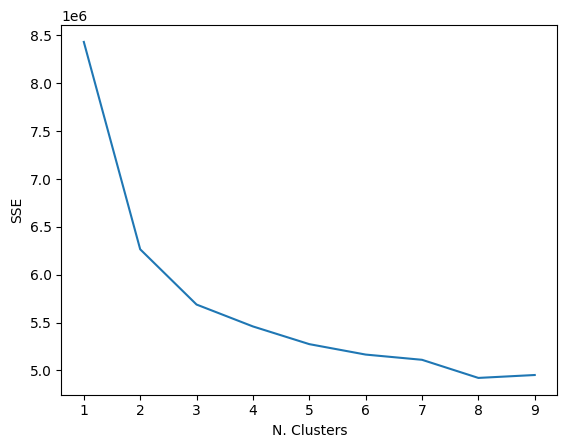

In [18]:
elbow = {} 

for k in range (1,10): #numero de clusters indo de 1 a 10
    kmeans_elbow = KMeans(n_clusters=k, n_init='auto').fit(feature_matrix_cv)
    elbow[k] = kmeans_elbow.inertia_

plt.figure()
plt.plot(list(elbow.keys()), list(elbow.values()))
plt.xlabel('N. Clusters')
plt.ylabel('SSE')
plt.show()

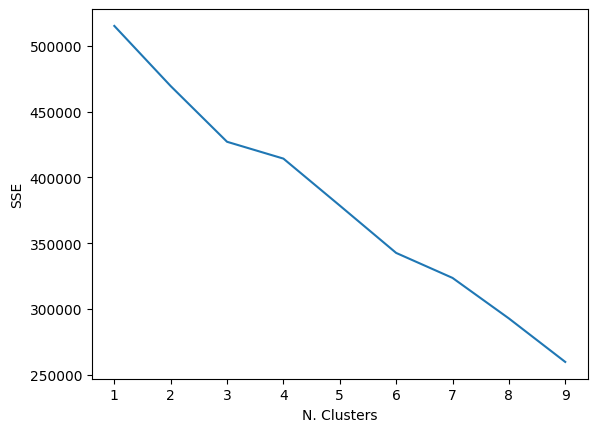

In [19]:
elbow = {} 

for k in range (1,10): #numero de clusters indo de 1 a 10
    kmeans_elbow = KMeans(n_clusters=k, n_init='auto').fit(feature_matrix_tfidf)
    elbow[k] = kmeans_elbow.inertia_

plt.figure()
plt.plot(list(elbow.keys()), list(elbow.values()))
plt.xlabel('N. Clusters')
plt.ylabel('SSE')
plt.show()

In [20]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [21]:
for n_cluster in range (2, 15):
    kmeans = KMeans(n_clusters=n_cluster, n_init='auto').fit(feature_matrix_cv)
    label = kmeans.labels_
    sil_coef = silhouette_score(feature_matrix_cv, label, metric='euclidean')
    print(f'Para n_clusters={n_cluster} o coeficiente de silhueta é de {sil_coef}')

Para n_clusters=2 o coeficiente de silhueta é de 0.5658456764670924
Para n_clusters=3 o coeficiente de silhueta é de 0.40644750736092533
Para n_clusters=4 o coeficiente de silhueta é de 0.35406152707069805
Para n_clusters=5 o coeficiente de silhueta é de 0.3520289235594496
Para n_clusters=6 o coeficiente de silhueta é de 0.2678941606485424
Para n_clusters=7 o coeficiente de silhueta é de 0.2261206539268337
Para n_clusters=8 o coeficiente de silhueta é de 0.1998139016951215
Para n_clusters=9 o coeficiente de silhueta é de 0.22853889945395575
Para n_clusters=10 o coeficiente de silhueta é de 0.23552866333236336
Para n_clusters=11 o coeficiente de silhueta é de 0.1729540460366686
Para n_clusters=12 o coeficiente de silhueta é de 0.23411841527918112
Para n_clusters=13 o coeficiente de silhueta é de 0.2443239299907241
Para n_clusters=14 o coeficiente de silhueta é de 0.14961419258542996


In [22]:
for n_cluster in range (2, 15):
    kmeans = KMeans(n_clusters=n_cluster, n_init='auto').fit(feature_matrix_tfidf)
    label = kmeans.labels_
    sil_coef = silhouette_score(feature_matrix_tfidf, label, metric='euclidean')
    print(f'Para n_clusters={n_cluster} o coeficiente de silhueta é de {sil_coef}')

Para n_clusters=2 o coeficiente de silhueta é de 0.33997831544853174
Para n_clusters=3 o coeficiente de silhueta é de 0.18539515860622566
Para n_clusters=4 o coeficiente de silhueta é de 0.17899089757604447
Para n_clusters=5 o coeficiente de silhueta é de 0.24029582521602613
Para n_clusters=6 o coeficiente de silhueta é de 0.2944547991038321
Para n_clusters=7 o coeficiente de silhueta é de 0.3447147392678966
Para n_clusters=8 o coeficiente de silhueta é de 0.30224319968854674
Para n_clusters=9 o coeficiente de silhueta é de 0.349865326758885
Para n_clusters=10 o coeficiente de silhueta é de 0.29324921287937267
Para n_clusters=11 o coeficiente de silhueta é de 0.37307784898747076
Para n_clusters=12 o coeficiente de silhueta é de 0.2870049559599632
Para n_clusters=13 o coeficiente de silhueta é de 0.25533097088917384
Para n_clusters=14 o coeficiente de silhueta é de 0.28178109003318863


In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=500)  # Substitua 500 pelo número desejado de componentes principais
dataset_reduced_cv = pca.fit_transform(feature_matrix_cv)
pd.DataFrame(dataset_reduced_cv)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.389433,3.424958,1.087143,0.444237,-1.103819,-1.001633,1.370253,-0.174799,-0.461542,0.453180,...,-0.085588,-0.191910,0.132780,0.163668,0.003633,-0.132157,-0.077391,0.011524,-0.074187,-0.107014
1,-1.661589,0.361640,-1.800825,-0.267077,-0.317959,0.329734,-2.503647,-0.470448,-0.007974,3.538570,...,-0.140844,-0.003145,-0.133150,-0.062200,-0.070259,0.002539,0.202740,-0.043830,0.120977,0.146270
2,7.734007,0.427211,2.855741,1.914693,5.627058,-3.040582,-1.425427,2.106231,-1.302585,2.005014,...,-0.009098,0.137922,0.262483,-0.028297,0.114462,0.494287,-0.051321,-0.154052,0.063906,0.026491
3,-4.367296,-0.131788,-0.603800,-0.149806,0.659100,0.022140,0.682208,-0.834324,0.439113,2.051070,...,0.233164,0.183391,0.109022,-0.211062,0.142316,-0.072636,-0.085090,-0.642633,0.061197,-0.004954
4,2.607887,0.503582,-1.729865,-3.154478,4.070576,-1.905871,-0.148437,-0.670304,1.010788,1.866461,...,-0.284156,-0.355041,-0.240402,-0.020749,-0.099896,-0.241873,0.105664,0.313302,0.102034,-0.474722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24650,-2.548024,-3.536835,-0.406329,-1.857130,-3.149570,0.252719,-0.973543,-0.165846,0.483262,-0.449772,...,-0.123539,0.098894,-0.035785,-0.132965,-0.171524,-0.024046,0.080397,0.122547,-0.091527,-0.044169
24651,-7.953615,-0.263146,-0.556446,-0.987964,-0.238760,0.335612,0.598305,-1.482971,0.113167,-1.895237,...,0.035279,-0.004485,0.027193,0.056788,-0.029908,-0.032102,-0.028674,0.003236,-0.041749,0.028140
24652,14.824344,-11.055555,3.572205,4.314399,-6.675248,6.002110,9.558898,-6.994552,-0.070379,-3.598048,...,-0.170426,-0.128747,0.140608,-0.136483,-0.098440,-0.167187,0.168612,0.027671,-0.046465,-0.053974
24653,-0.759115,3.942302,-0.116819,-1.235480,0.477022,-0.451095,-1.990662,-0.619037,-0.455244,1.573722,...,-0.049549,-0.268931,0.306652,0.116330,-0.029946,-0.098024,-0.062212,-0.043807,-0.072860,0.069284


In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=500)  # Substitua 500 pelo número desejado de componentes principais
dataset_reduced_tfidf = pca.fit_transform(feature_matrix_tfidf)
pd.DataFrame(dataset_reduced_tfidf)

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-0.751547,-0.235961,-1.870698,1.017026,-1.106367,0.303700,-0.149969,-2.006899,0.200021,0.590082,...,-0.000349,-0.001075,0.000480,-0.000607,0.002746,0.003045,0.011036,0.006701,-0.018885,-0.027003
1,-0.614135,-0.019609,-0.659379,0.832690,-0.205732,-0.043120,-0.240494,-0.472595,0.092224,0.047692,...,0.010340,0.003719,0.009767,0.007522,-0.012190,0.014350,-0.013404,-0.004897,0.015685,0.003706
2,-0.717469,1.328351,-0.599587,-0.520818,0.743106,-0.193601,0.041398,1.103092,-0.082736,-0.330235,...,0.026304,-0.006168,0.017298,0.020144,0.003844,-0.003240,0.024946,0.014004,0.002639,0.003971
3,0.224536,0.195284,-0.863993,0.654968,-0.370172,-0.359034,-0.235663,-0.528927,0.083116,0.103718,...,0.004223,0.005940,0.010046,0.013913,0.016180,-0.008301,0.010027,0.001386,-0.019964,0.013369
4,-0.181820,0.158670,-1.023852,0.601351,-0.504977,-0.081246,-0.168597,-0.812202,0.096434,0.203593,...,-0.003554,0.040522,0.021533,-0.043464,0.028342,0.018216,0.008525,-0.021390,-0.041861,-0.024403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24650,0.027730,0.116165,-1.044846,0.713968,-0.507662,-0.222752,-0.212492,-0.797963,0.104617,0.191934,...,0.006381,-0.029828,0.017759,-0.000222,-0.005020,-0.001983,0.004836,0.012322,-0.010859,0.011687
24651,6.064907,1.906526,0.918506,2.623180,0.373763,0.233344,-1.954134,0.210474,-0.044279,0.118247,...,-0.004766,0.000306,-0.000174,0.002540,-0.000363,0.003855,-0.005234,-0.000712,-0.000165,-0.001770
24652,-0.356579,-1.143566,4.099272,-1.288885,-3.608540,1.902314,1.377739,-1.370974,7.790918,-11.644170,...,0.013538,-0.001617,0.004890,0.007306,-0.011977,-0.013243,-0.004295,0.003098,-0.001183,-0.004814
24653,-1.470929,0.353291,-0.980777,0.429852,0.029263,0.301139,-0.076395,-0.308311,0.063374,0.042646,...,-0.017856,-0.018687,0.001827,-0.015881,-0.011001,0.015157,-0.002501,0.029452,0.001517,0.017190


In [25]:
from sklearn.metrics import adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score, silhouette_score

class Metricas:

    def __init__(self, silhueta=0, calinski_harabasz=0, davies_bouldin=0, rand=0, inercia=0):
        self.silhueta = silhueta
        self.calinski_harabasz = calinski_harabasz
        self.davies_bouldin = davies_bouldin
        self.rand = rand
        self.inercia = inercia

class Cluster:
    def __init__(self, numeroClusters, metricas):
        self.numeroClusters = numeroClusters
        self.metricas = metricas

resultados = []

for n_cluster in range (2, 15):
    kmeans = KMeans(n_clusters=n_cluster, n_init='auto').fit(feature_matrix_tfidf)
    label = kmeans.labels_
    metricas = Metricas(
        silhueta=silhouette_score(feature_matrix_tfidf, label, metric='euclidean'),
        calinski_harabasz=calinski_harabasz_score(feature_matrix_tfidf, label),
        davies_bouldin=davies_bouldin_score(feature_matrix_tfidf, label),
        # adjusted_rand_score(feature_matrix_tfidf, label),
        inercia=kmeans.inertia_
    )
    cluster = Cluster(n_cluster, metricas)
    resultados.append(cluster)
    

In [32]:
saida = []

for resultado in resultados:
    output = []
    output.append(resultado.numeroClusters)
    output.append(resultado.metricas.silhueta)
    output.append(resultado.metricas.calinski_harabasz)
    output.append(resultado.metricas.davies_bouldin)
    output.append(resultado.metricas.inercia)
    saida.append(output)

In [34]:
colunas = ['num_clusters', 'silhueta', 'calinski_harabasz', 'davies_bouldin', 'inercia']
pd.DataFrame(columns=colunas, data=saida)

,num_clusters,silhueta,calinski_harabasz,davies_bouldin,inercia
0,2,0.233697,1694.862734,2.649322,482040.120848
1,3,0.561352,1424.389697,0.423404,461812.793542
2,4,0.217128,1910.363546,1.900475,417999.430263
3,5,0.285664,2465.464717,1.504572,367965.731599
4,6,0.298823,2354.521059,1.419563,348657.510113
5,7,0.303591,2500.161043,1.202337,320264.365930
6,8,0.360217,2852.256790,1.082018,284618.687050
7,9,0.264104,2763.964531,1.250851,271551.343737
8,10,0.364576,3244.136382,0.883203,235811.297219
9,11,0.261990,2798.783984,1.165275,241224.520305
